# Import

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
# from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Data

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Renewable.csv')

In [3]:
df.head()

,Time,Energy delta[Wh],GHI,temp,pressure,humidity,wind_speed,rain_1h,snow_1h,clouds_all,isSun,sunlightTime,dayLength,SunlightTime/daylength,weather_type,hour,month
0,2017-01-01 00:00:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.0,4,0,1
1,2017-01-01 00:15:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.0,4,0,1
2,2017-01-01 00:30:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.0,4,0,1
3,2017-01-01 00:45:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.0,4,0,1
4,2017-01-01 01:00:00,0,0.0,1.7,1020,100,5.2,0.0,0.0,100,0,0,450,0.0,4,1,1


In [4]:
df.info()
# 결측치 없음
# Time : to_datetime 필요
# isSun, weather_type : Encoding 필요

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196776 entries, 0 to 196775
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Time                    196776 non-null  object 
 1   Energy delta[Wh]        196776 non-null  int64  
 2   GHI                     196776 non-null  float64
 3   temp                    196776 non-null  float64
 4   pressure                196776 non-null  int64  
 5   humidity                196776 non-null  int64  
 6   wind_speed              196776 non-null  float64
 7   rain_1h                 196776 non-null  float64
 8   snow_1h                 196776 non-null  float64
 9   clouds_all              196776 non-null  int64  
 10  isSun                   196776 non-null  int64  
 11  sunlightTime            196776 non-null  int64  
 12  dayLength               196776 non-null  int64  
 13  SunlightTime/daylength  196776 non-null  float64
 14  weather_type        

In [5]:
df['Time'] = pd.to_datetime(df['Time'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196776 entries, 0 to 196775
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Time                    196776 non-null  datetime64[ns]
 1   Energy delta[Wh]        196776 non-null  int64         
 2   GHI                     196776 non-null  float64       
 3   temp                    196776 non-null  float64       
 4   pressure                196776 non-null  int64         
 5   humidity                196776 non-null  int64         
 6   wind_speed              196776 non-null  float64       
 7   rain_1h                 196776 non-null  float64       
 8   snow_1h                 196776 non-null  float64       
 9   clouds_all              196776 non-null  int64         
 10  isSun                   196776 non-null  int64         
 11  sunlightTime            196776 non-null  int64         
 12  dayLength               196776

# EDA

## Energy delta

In [7]:
print(df['Energy delta[Wh]'].describe())

count    196776.000000
mean        573.008228
std        1044.824047
min           0.000000
25%           0.000000
50%           0.000000
75%         577.000000
max        5020.000000
Name: Energy delta[Wh], dtype: float64


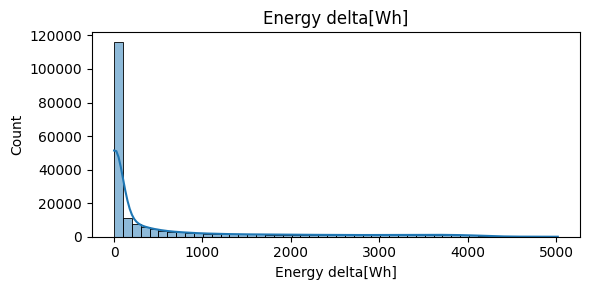

In [8]:
plt.figure(figsize = (6,3))
sns.histplot(df['Energy delta[Wh]'], bins = 50, kde = True)
plt.title('Energy delta[Wh]')
plt.xlabel('Energy delta[Wh]')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 대부분의 값이 0~500Wh 구간에 몰려 있음

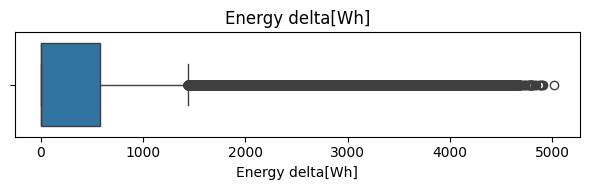

In [9]:
plt.figure(figsize = (6,2))
sns.boxplot(x = df['Energy delta[Wh]'])
plt.title('Energy delta[Wh]')
plt.tight_layout()
plt.show()

# 2000~5000Wh 사이에 다수의 이상치 존재 -> Boxplot 상의 이상치일 뿐 제거하지 않아도 됨

## Energey delta(target)와 다른 column들의 관계

In [10]:
target = 'Energy delta[Wh]'

### Energy delta <-> 수치형 column
- GHI, temp, pressure, humidity, wind_speed, rain_1h, snow_1h, clouds_all, sunLightTime, dayLength, SunLightTime/daylength

In [11]:
features = [
    'GHI', 'temp', 'pressure', 'humidity',
    'wind_speed', 'rain_1h', 'snow_1h', 'clouds_all',
    'sunlightTime', 'dayLength', 'SunlightTime/daylength'
]

In [12]:
corrs = df[features + [target]].corr()[target].sort_values(ascending = False)
print("Feature ↔ Target Correlations:\n", corrs)

Feature ↔ Target Correlations:
 Energy delta[Wh]          1.000000
GHI                       0.914619
sunlightTime              0.437296
SunlightTime/daylength    0.402523
temp                      0.378554
dayLength                 0.280695
pressure                  0.115219
wind_speed                0.029385
snow_1h                  -0.050914
rain_1h                  -0.059881
clouds_all               -0.190241
humidity                 -0.544407
Name: Energy delta[Wh], dtype: float64


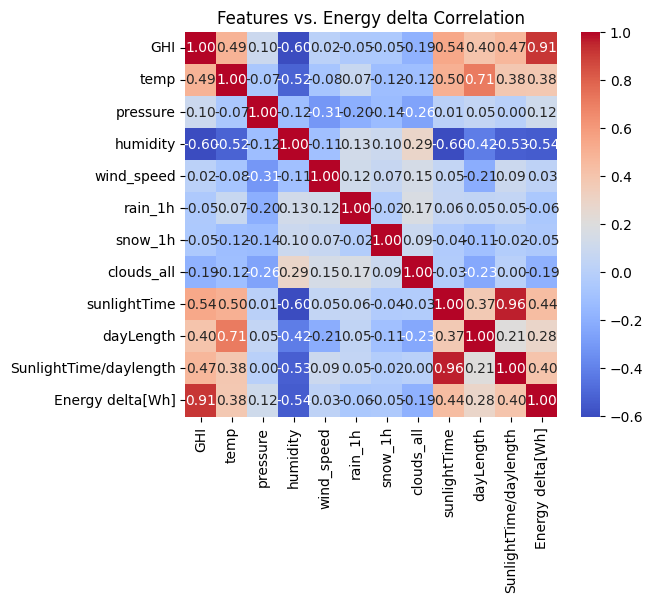

In [13]:
plt.figure(figsize = (6,5))
sns.heatmap(df[features + [target]].corr(), cmap = 'coolwarm', annot = True, fmt = '.2f')
plt.title('Features vs. Energy delta Correlation')
plt.show()

# Energy delta와 가장 관련 있는 feature는 GHI (-0.91)
# Energy delta와 가장 관련 없는 feature는 wind_speed (0.03)
# 강한 양 상관 : GHI, sunlightTime
# 강한 음 상관 : humidity
# 0에 가까워 의미 없는 상관 : wind_speed, rain_1h, snow_1h, pressure
# 우선순위 높은 피처 : GHI, sunlightTime, SunlightTime/daylength, humidity, temp

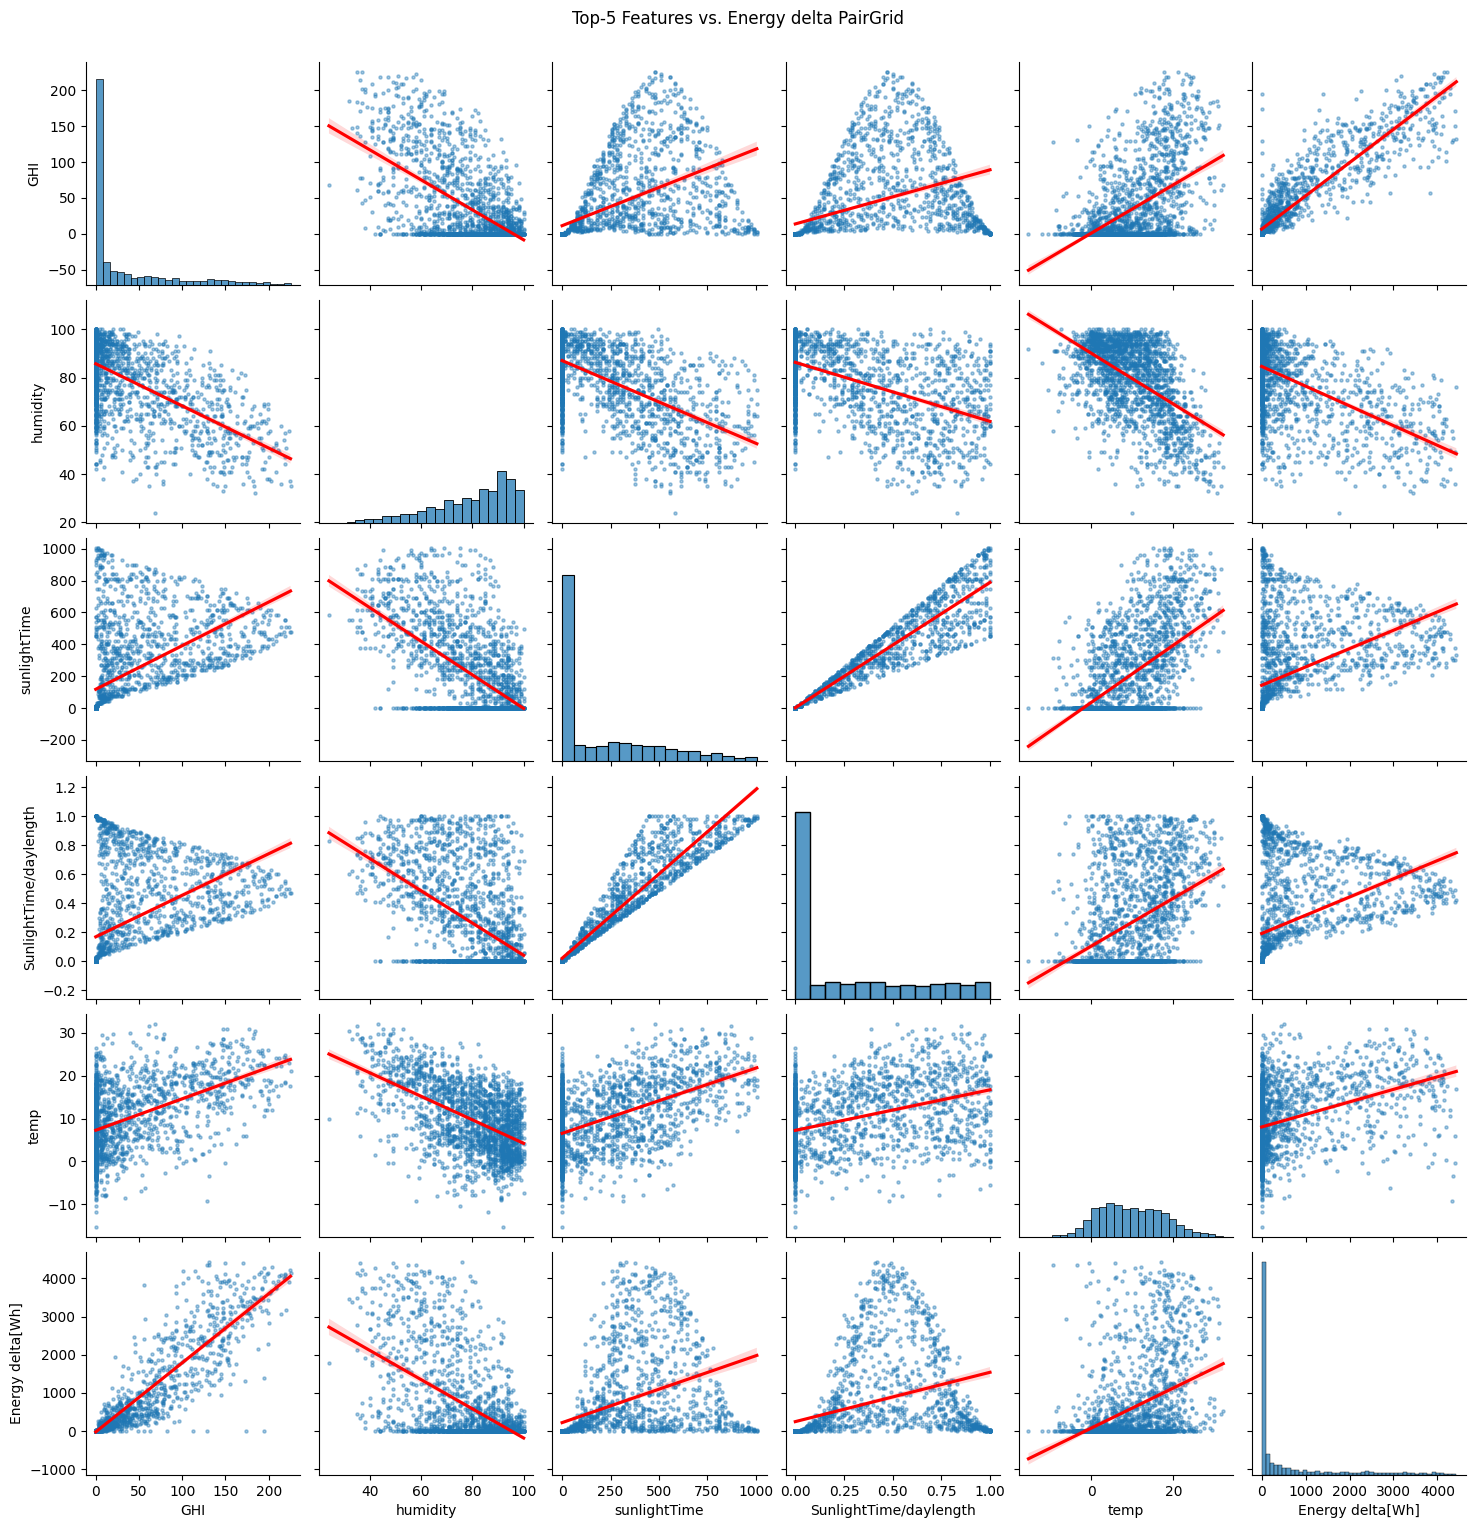

In [14]:
top5 = corrs.drop(target).abs().sort_values(ascending = False).head(5).index.tolist()
sns.pairplot(df[top5 + [target]].sample(2000, random_state = 1),
             kind = 'reg', plot_kws = {'line_kws':{'color':'red'}, 'scatter_kws':{'s':5,'alpha':0.4}})
plt.suptitle('Top-5 Features vs. Energy delta PairGrid', y = 1.02)
plt.show()

# GHI
# 히스토그램 : 0에 대부분 몰려 있음
# 양의 상관 관계 : sunlightTime, SunlightTime/dayLength, temp, Energy delta
# 음의 상관 관계 : humidity

# humidity
# 히스토그램 : 대부분 40~100% 사이
# 양의 상관 관계 : X
# 음의 상관 관계 : GHI, sunlightTime, SunlightTime/dayLength, temp, Energy delta

# sunlightTime
# 히스토그램 : 0분(야간)이 압도적
# 양의 상관 관계 : GHI, SunlightTime/dayLength, temp, Energy delta
# 음의 상관 관계 : humidity

# SunlightTime/dayLength
# 히스토그램 : 0~1 범위 내에서 고르게 분포
# 양의 상관 관계 : GHI, sunlightTime, temp, Energy delta
# 음의 상관 관계 : humidity

# temp
# 히스토그램 : -5~35°C 사이 종 모양
# 양의 상관 관계 : GHI, sunlightTime, SunlightTime/dayLength, Energy delta
# 음의 상관 관계 : humidity

# Energy delta
# 히스토그램 : 0이 압도
# 양의 상관 관계 : GHI, sunlightTime, SunlightTime/dayLength, temp
# 음의 상관 관계 : humidity

### Energy delta <-> 범주형 column
- isSun, weather_type

/tmp/ipython-input-15-1159619238.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = col, y = target, data = df, palette = 'pastel')


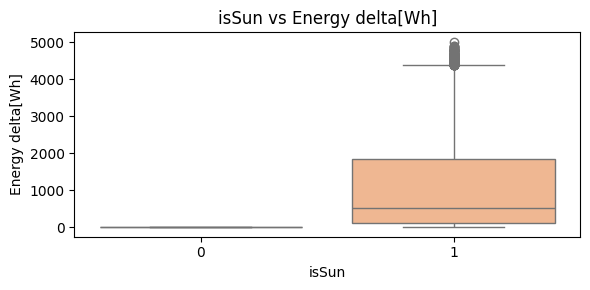

/tmp/ipython-input-15-1159619238.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = col, y = target, data = df, palette = 'pastel')


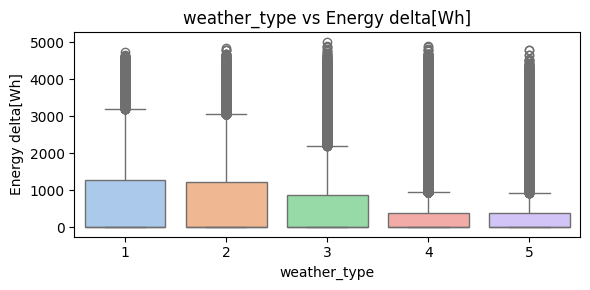

In [15]:
cat_feats = ['isSun', 'weather_type']
for col in cat_feats:
    plt.figure(figsize = (6,3))
    sns.boxplot(x = col, y = target, data = df, palette = 'pastel')
    plt.title(f'{col} vs {target}')
    plt.tight_layout()
    plt.show()

# isSun
# isSun = 0 (야간) : 대부분의 데이터가 0, 빛이 없으면 발전량이 거의 0임
# isSun = 1 (낮) : 중앙값 약 400Wh

# weather_type
# 1, 2 : 발전량이 높고 변동 폭도 큼
# 3 : 발전량이 줄어듦
# 4, 5 : 거의 발전이 일어나지 않음

### Energy delta <-> 날짜, 시간 column
- Time, hour, month

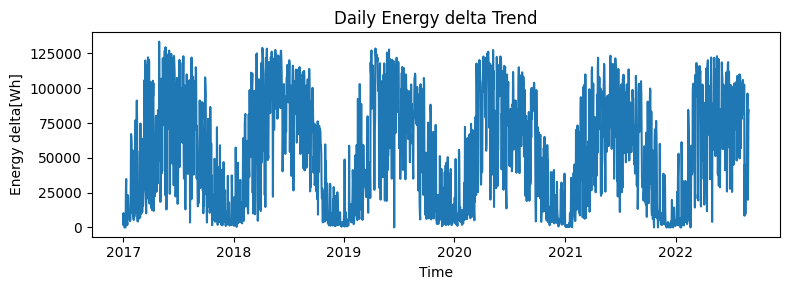

In [16]:
daily = df.set_index('Time')[target].resample('D').sum().reset_index()
plt.figure(figsize = (8,3))
sns.lineplot(x = 'Time', y = target, data = daily)
plt.title('Daily Energy delta Trend')
plt.tight_layout()
plt.show()

# 봄, 여름에 발전량 증가하고 가을, 겨울에는 감소함

/tmp/ipython-input-17-2639863636.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = 'hour', y = target, data = df, palette = 'coolwarm')


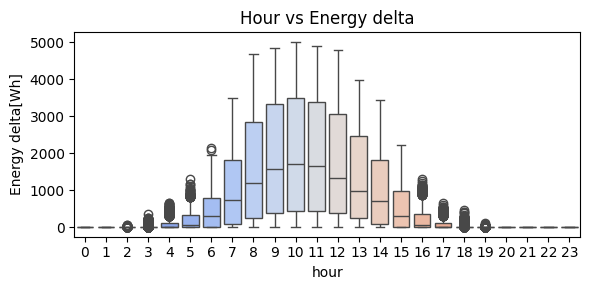

In [17]:
plt.figure(figsize = (6,3))
sns.boxplot(x = 'hour', y = target, data = df, palette = 'coolwarm')
plt.title('Hour vs Energy delta')
plt.tight_layout()
plt.show()

# 야간 (0~4, 18~23) : 발전량이 거의 0
# 이른 아침 (5~6) : 소량의 발전 시작
# 오전 (7~9) : 발전량 급격히 상승
# 정오 전후 (10~12) : 최고점 및 최대값
# 오후 (13~16) : 점차 하락
# 늦은 오후 (17~18) : 발전량 급격히 감사

/tmp/ipython-input-18-3173158010.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = 'month', y = target, data = df, palette = 'Spectral')


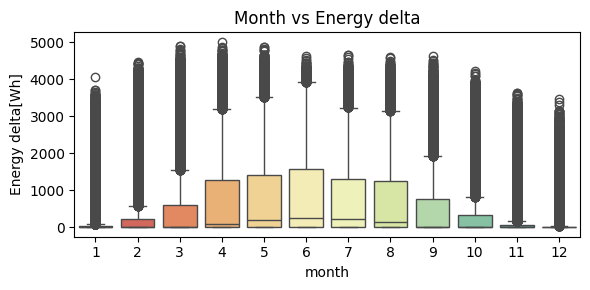

In [18]:
plt.figure(figsize = (6,3))
sns.boxplot(x = 'month', y = target, data = df, palette = 'Spectral')
plt.title('Month vs Energy delta')
plt.tight_layout()
plt.show()

# 겨울 (1~2, 11~12) : 발전이 거의 일어나지 않음
# 봄 (3~5) : 발전량이 빠르게 증가
# 여름 (6~8) : 최대 발전량
# 가을 (9~10) : 서서히 하락

## Energy delta 제외한 column

In [19]:
features = [c for c in df.columns if c != 'Energy delta[Wh]' and c != 'Time']

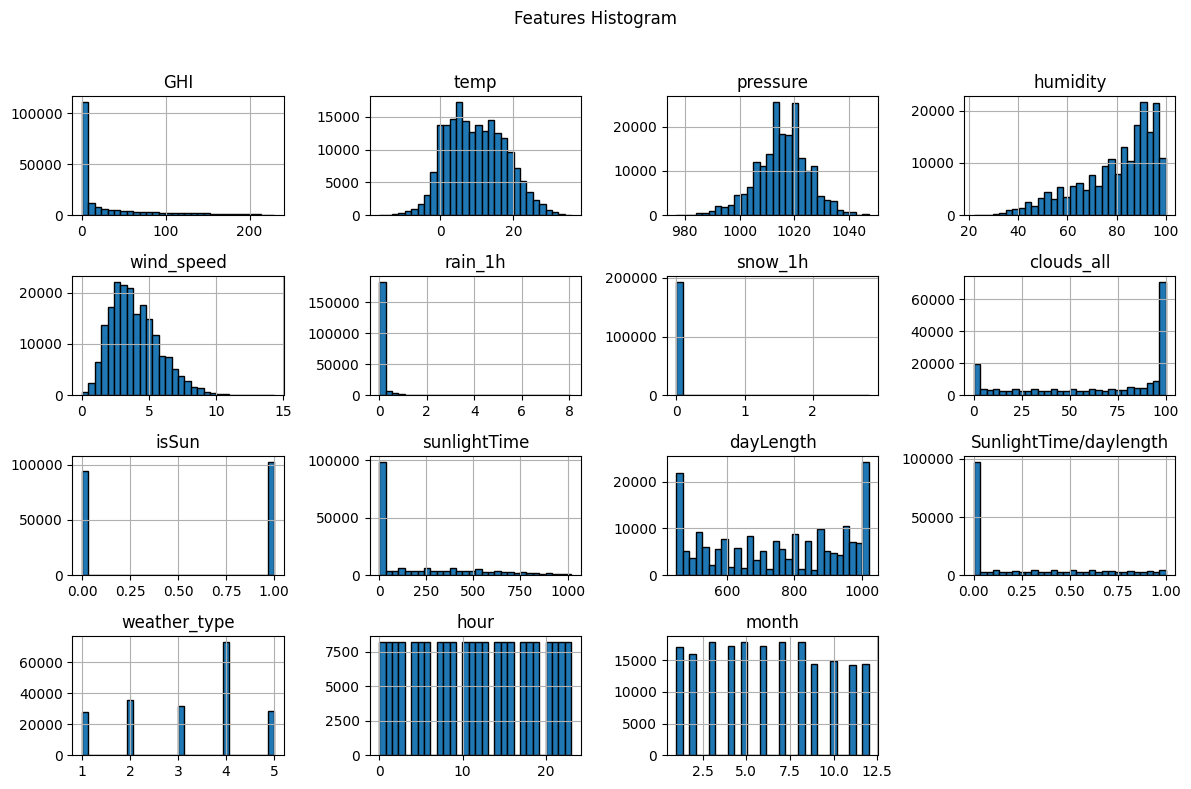

In [20]:
df[features].hist(bins = 30, figsize = (12, 8), layout = (4, 4), edgecolor = 'black')
plt.suptitle('Features Histogram')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

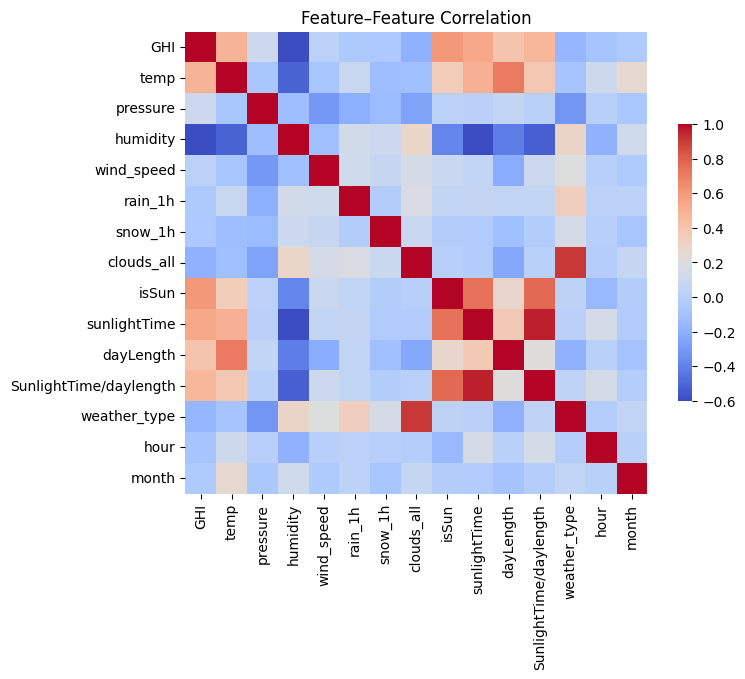

In [21]:
corr = df[features].corr()
plt.figure(figsize = (8, 6))
sns.heatmap(corr, cmap = 'coolwarm', annot = False, square = True, cbar_kws = {'shrink': .6})
plt.title('Feature–Feature Correlation')
plt.show()

# MODEL

In [22]:
FEATURES = [
    'GHI',
    'sunlightTime',
    'dayLength',
    'SunlightTime/daylength',
    'humidity',
    'temp',
    'isSun',
    'hour',
    'month',
    'pressure',
    'clouds_all',
    'wind_speed',
    'rain_1h',
    'snow_1h',
    'weather_type'
]

TARGET = 'Energy delta[Wh]'

# GHI, sunlightTime -> 로그 변환
# 수치형 피처 -> 스케일링
# hour, month -> 사인.코사인 인코딩

In [23]:
X = df[FEATURES].copy()
y = df[TARGET].copy()

In [24]:
print("X shape :", X.shape)
print("y shape :", y.shape)

X shape : (196776, 15)
y shape : (196776,)


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [26]:
print("X_train shape :", X_train.shape)
print("X_test shape :", X_test.shape)
print("y_train shape :", y_train.shape)
print("y_test shape :", y_test.shape)

X_train shape : (157420, 15)
X_test shape : (39356, 15)
y_train shape : (157420,)
y_test shape : (39356,)


In [27]:
# 사인.코사인 인코딩 (hour, month)

def cyclic_features(df):
    return pd.DataFrame({
        'hour_sin' : np.sin(2 * np.pi * df['hour'] / 24),
        'hour_cos' : np.cos(2 * np.pi * df['hour'] / 24),
        'month_sin' : np.sin(2 * np.pi * (df['month'] - 1) / 12),
        'month_cos' : np.cos(2 * np.pi * (df['month'] - 1) / 12),
    }, index = df.index)

cyclic_tf = FunctionTransformer(cyclic_features, validate = False)

In [29]:
preprocessor = ColumnTransformer([
    # 로그 변환 (GHI, sunlightTime)
    ('log',   FunctionTransformer(np.log1p, validate = False), ['GHI', 'sunlightTime']),
    # 스케일링 (수치형 피처)
    ('scale', StandardScaler(),
     ['dayLength', 'SunlightTime/daylength', 'humidity', 'temp', 'isSun', 'pressure', 'clouds_all', 'wind_speed', 'snow_1h', 'rain_1h']),
    # 사인.코사인 인코딩 (hour, month)
    ('cyc',   cyclic_tf, ['hour', 'month']),
    # 원핫 인코딩 (weather_type)
    ('cat', OneHotEncoder(sparse_output = False, handle_unknown = 'ignore'), ['weather_type'])
], remainder = 'drop')

In [30]:
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc  = preprocessor.transform(X_test)

In [31]:
print("X_train_proc shape:", X_train_proc.shape)
print("X_test_proc  shape:", X_test_proc.shape)

X_train_proc shape: (157420, 21)
X_test_proc  shape: (39356, 21)


In [32]:
model_dict = {
    'LinearRegression' :        LinearRegression(),
    'DecisionTree' :            DecisionTreeRegressor(random_state = 1),
    'RandomForest' :            RandomForestRegressor(random_state = 1),
    'AdaBoost' :                AdaBoostRegressor(random_state = 1),
    'GradientBoosting' :        GradientBoostingRegressor(random_state = 1),
    'XGBoost' :                 XGBRegressor(random_state = 1, verbosity = 0)
}

In [33]:
results = []

for name, estimator in model_dict.items():
    pipe = Pipeline([
        ('pre', preprocessor),
        ('est', estimator)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2   = r2_score(y_test, y_pred)
    results.append((name, rmse, r2))
    print(f"{name:17s} → RMSE: {rmse:7.2f} Wh, R²: {r2:.3f}")

LinearRegression  → RMSE:  554.27 Wh, R²: 0.718
DecisionTree      → RMSE:  381.77 Wh, R²: 0.866
RandomForest      → RMSE:  269.80 Wh, R²: 0.933
AdaBoost          → RMSE:  428.73 Wh, R²: 0.831
GradientBoosting  → RMSE:  307.54 Wh, R²: 0.913
XGBoost           → RMSE:  272.80 Wh, R²: 0.932


In [34]:
df_results = pd.DataFrame(results, columns = ['Model', 'RMSE', 'R2']).set_index('Model')
print("\n=== 성능 비교 ===")
print(df_results.sort_values('RMSE'))

# RandomForest와 XGBoost의 성능 차이가 크게 없어 두 모델을 가지고 파라미터 조정 후 정확도 비교 예정


=== 성능 비교 ===
                        RMSE        R2
Model                                 
RandomForest      269.802219  0.933155
XGBoost           272.795926  0.931663
GradientBoosting  307.544597  0.913145
DecisionTree      381.771388  0.866161
AdaBoost          428.734871  0.831207
LinearRegression  554.272384  0.717887


## RandomForest

In [35]:
rf_param_dist = {
    'est__n_estimators' : randint(50, 300),
    'est__max_depth' : randint(3, 20),
    'est__min_samples_split' : randint(2, 10),
    'est__min_samples_leaf' : randint(1, 5),
    'est__max_features' : ['auto', 'sqrt', 'log2', 0.5, 0.8]
}

In [36]:
pipe = Pipeline([
    ('pre', preprocessor),
    ('est', RandomForestRegressor(random_state = 1, n_jobs = -1))
])

In [39]:
rs = RandomizedSearchCV(
    estimator = pipe,
    param_distributions = rf_param_dist,
    n_iter = 12,
    scoring = 'neg_root_mean_squared_error',
    cv = 3,
    n_jobs = -1,
    verbose = 1,
    random_state = 1
)

In [40]:
rs.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
6 fits failed out of a total of 36.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **last

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pre',
                                              ColumnTransformer(transformers=[('log',
                                                                               FunctionTransformer(func=<ufunc 'log1p'>),
                                                                               ['GHI',
                                                                                'sunlightTime']),
                                                                              ('scale',
                                                                               StandardScaler(),
                                                                               ['dayLength',
                                                                                'SunlightTime/daylength',
                                                                                'humidity',
                                                                                'temp',
                                                                                'isSun',
                                                                                'pressure',
                                                                                'clouds_all',
                                                                                'wind_speed',
                                                                                'snow_1h',
                                                                                'rain_1h']),
                                                                              ('cyc',
                                                                               FunctionTransformer(func=<functio...
                                        'est__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x78145d6b0b50>,
                                        'est__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x78145d6b3b90>,
                                        'est__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x78145d4c8b90>},
                   random_state=1, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [41]:
best_params = rs.best_params_
best_score = -rs.best_score_
print("Best RMSE (CV) :", best_score)
print("Best parameters :", best_params)

Best RMSE (CV) : 269.41014919496087
Best parameters : {'est__max_depth': 17, 'est__max_features': 'log2', 'est__min_samples_leaf': 1, 'est__min_samples_split': 9, 'est__n_estimators': 265}


In [42]:
best_pipe = rs.best_estimator_

In [43]:
y_pred_test = best_pipe.predict(X_test)

In [44]:
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

print(f"▶ Test RMSE: {rmse_test:.2f} Wh")
print(f"▶ Test R²  : {r2_test:.3f}")

▶ Test RMSE: 267.19 Wh
▶ Test R²  : 0.934


## XGBoost

In [45]:
param_dist = {
    'est__n_estimators' : randint(50, 300),
    'est__max_depth' : randint(3, 10),
    'est__learning_rate' : uniform(0.01, 0.29),
    'est__subsample' : uniform(0.5, 0.5),
    'est__colsample_bytree' : uniform(0.5, 0.5)
}

In [46]:
pipe = Pipeline([
    ('pre', preprocessor),
    ('est', XGBRegressor(random_state = 1, verbosity = 0))
])

In [47]:
rs = RandomizedSearchCV(
    pipe,
    param_distributions = param_dist,
    n_iter = 25,
    scoring = 'neg_root_mean_squared_error',
    n_jobs = -1,
    cv = 5,
    verbose = 1,
    random_state = 1
)

In [48]:
rs.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('pre',
                                              ColumnTransformer(transformers=[('log',
                                                                               FunctionTransformer(func=<ufunc 'log1p'>),
                                                                               ['GHI',
                                                                                'sunlightTime']),
                                                                              ('scale',
                                                                               StandardScaler(),
                                                                               ['dayLength',
                                                                                'SunlightTime/daylength',
                                                                                'humidity',
                                                                                'temp',
                                                                                'isSun',
                                                                                'pressure',
                                                                                'clouds_all',
                                                                                'wind_speed',
                                                                                'snow_1h',
                                                                                'rain_1h']),
                                                                              ('cyc',
                                                                               FunctionTransformer(func=<functio...
                                        'est__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x78145d4f3bd0>,
                                        'est__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x78145d4f3790>,
                                        'est__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x78145d4f2110>},
                   random_state=1, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [49]:
best_params = rs.best_params_
best_score = -rs.best_score_
print("Best RMSE (CV) :", best_score)
print("Best parameters :", best_params)

Best RMSE (CV) : 259.34532470703124
Best parameters : {'est__colsample_bytree': np.float64(0.831720748909224), 'est__learning_rate': np.float64(0.1902917588606453), 'est__max_depth': 7, 'est__n_estimators': 270, 'est__subsample': np.float64(0.9747446293535356)}


In [50]:
best_pipe = rs.best_estimator_

In [51]:
y_pred_test = best_pipe.predict(X_test)

In [52]:
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

print(f"▶ Test RMSE: {rmse_test:.2f} Wh")
print(f"▶ Test R²  : {r2_test:.3f}")

▶ Test RMSE: 260.95 Wh
▶ Test R²  : 0.937


## 최종 모델 - XGBoost

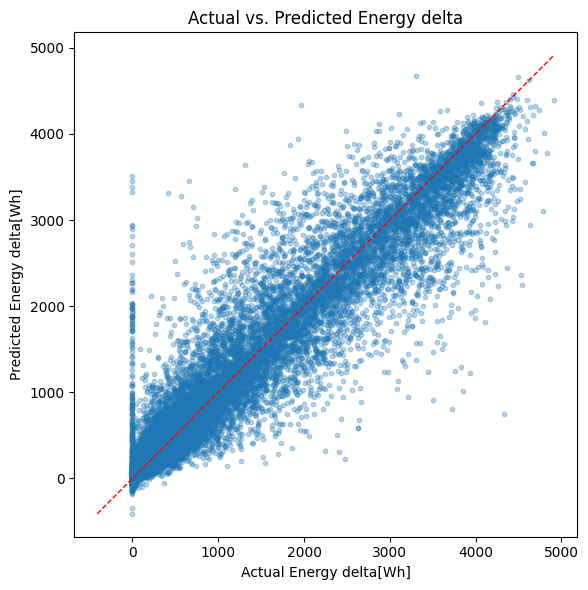

In [53]:
plt.figure(figsize = (6, 6))
plt.scatter(y_test, y_pred, s = 10, alpha = 0.3)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth = 1)
plt.xlabel('Actual Energy delta[Wh]')
plt.ylabel('Predicted Energy delta[Wh]')
plt.title('Actual vs. Predicted Energy delta')
plt.tight_layout()
plt.show()

In [54]:
fi = best_pipe.named_steps['est'].feature_importances_

In [55]:
try:
    fn = best_pipe.named_steps['pre'].get_feature_names_out()
except:
    log_feats = ['GHI', 'sunlightTime']
    scale_feats = [
        'dayLength', 'SunlightTime/daylength', 'humidity', 'temp','isSun',
        'pressure', 'clouds_all', 'wind_speed', 'rain_1h', 'snow_1h'
    ]
    cyclic_feats = ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']
    cat_feats = best_pipe.named_steps['pre'] \
                    .named_transformers_['cat'] \
                    .get_feature_names_out(['weather_type']).tolist()
    fn = np.concatenate([log_feats, scale_feats, cyclic_feats, cat_feats])

In [56]:
imp = pd.Series(fi, index = fn).sort_values(ascending = False)
print(imp)

GHI                       0.594464
dayLength                 0.090020
SunlightTime/daylength    0.037123
hour_sin                  0.033411
weather_type_5            0.032104
month_cos                 0.028554
weather_type_1            0.027546
hour_cos                  0.027073
weather_type_4            0.020922
clouds_all                0.014511
humidity                  0.013387
month_sin                 0.011598
sunlightTime              0.009901
weather_type_2            0.009463
temp                      0.009428
snow_1h                   0.009224
wind_speed                0.007712
pressure                  0.007630
rain_1h                   0.006259
weather_type_3            0.005008
isSun                     0.004663
dtype: float32


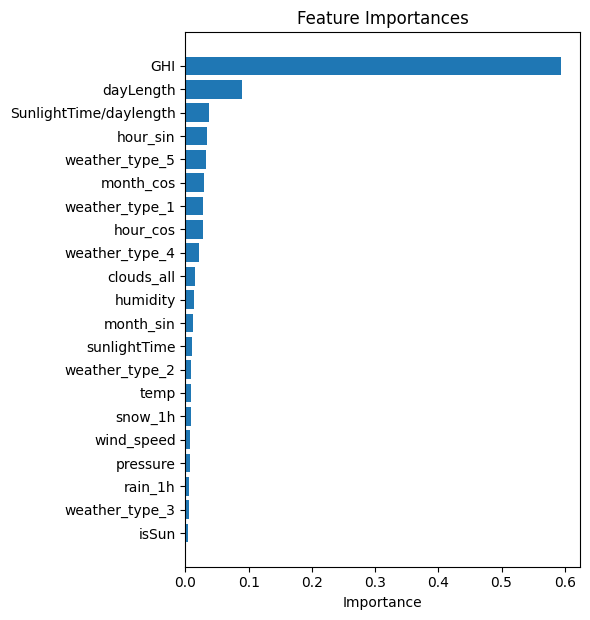

In [57]:
plt.figure(figsize = (6, len(imp) * 0.3))
plt.barh(imp.index, imp.values)
plt.gca().invert_yaxis()
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()